In [3]:
import os
import torch
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from models.utils import load_model_and_state
from datasets.CustomDataset import CustomImageDataset
from datasets.transforms import get_transform
from utils.visualization import denormalize
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print(torch.cuda.is_available())

True


In [2]:
# ŁADOWANIE DANYCH
img_set = 1
color_mode = 'L'
input_shape = (512, 512)

transform = get_transform(color_mode, input_shape)

# OBRAZY TRENINGOWE
img_dirs = ['./data/train/set' + str(img_set)]
dataset = CustomImageDataset(img_dirs=img_dirs, transform=transform, color_mode=color_mode)
print(f"Liczba obrazów w datasettie: {len(dataset)}")
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0)

# OBRAZY TESTOWE DO WYŚWIETLENIA WYNIKU
print_img_dir = ['./data/test/set' + str(img_set)]
print_dataset = CustomImageDataset(img_dirs=print_img_dir, transform=transform, color_mode=color_mode)
print_loader = DataLoader(print_dataset, batch_size=8, shuffle=False)

# DLA PCA OBRAZY TRENINGOWE I TESTOWE
train_img_dirs = ['./data/train/set' + str(img_set)]
test_img_dirs = ['./data/test/set' + str(img_set)]

# przygotowanie datasetów i DataLoaderów dla każdego folderu treningowego i testowego
train_datasets = [CustomImageDataset(img_dirs=[img_dir], transform=transform, color_mode=color_mode) for img_dir in train_img_dirs]
train_loaders = [DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0) for dataset in train_datasets]

test_datasets = [CustomImageDataset(img_dirs=[img_dir], transform=transform, color_mode=color_mode) for img_dir in test_img_dirs]
test_loaders = [DataLoader(dataset, batch_size=8, shuffle=False) for dataset in test_datasets]


Liczba obrazów w datasettie: 99


In [ ]:
# OBLICZENIE MEAN I STD DLA ZBIORU OBRAZÓW
def mean_std_to_normalisation(dataset):
    """
    Oblicza średnią i odchylenie standardowe dla zestawu obrazów w skali szarości.
    """
    mean = np.mean(dataset)
    std = np.std(dataset)
    
    return mean, std

print(mean_std_to_normalisation(train_datasets))

In [ ]:
# Przykładowe wyświetlenie kilku obrazów z augmentacji
# import matplotlib.pyplot as plt

# def show_images(images, nmax=4):
#     fig, axs = plt.subplots(1, nmax, figsize=(15,15))
#     for i in range(nmax):
#         axs[i].imshow(images[i][0], cmap='gray')
#         axs[i].axis('off')
#     plt.show()

# data_iter = iter(data_loader)
# images = next(data_iter)
# show_images(images)


In [4]:
# ŁADOWANIE MODELU
model_path = './saved_models/ResCAE'
device = 'cuda'
model, optimizer, epoch = load_model_and_state(model_path)
model.eval()

c:\Users\skuba\OneDrive\Pulpit\vae_project_2\models\utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_filepath)
c:\Users\skuba\OneDrive\Pul

ResidualAutoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (1): Sequential(
      (0): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    )
    (2): Sequential(
      (0): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (1): LeakyReLU(negative_sl

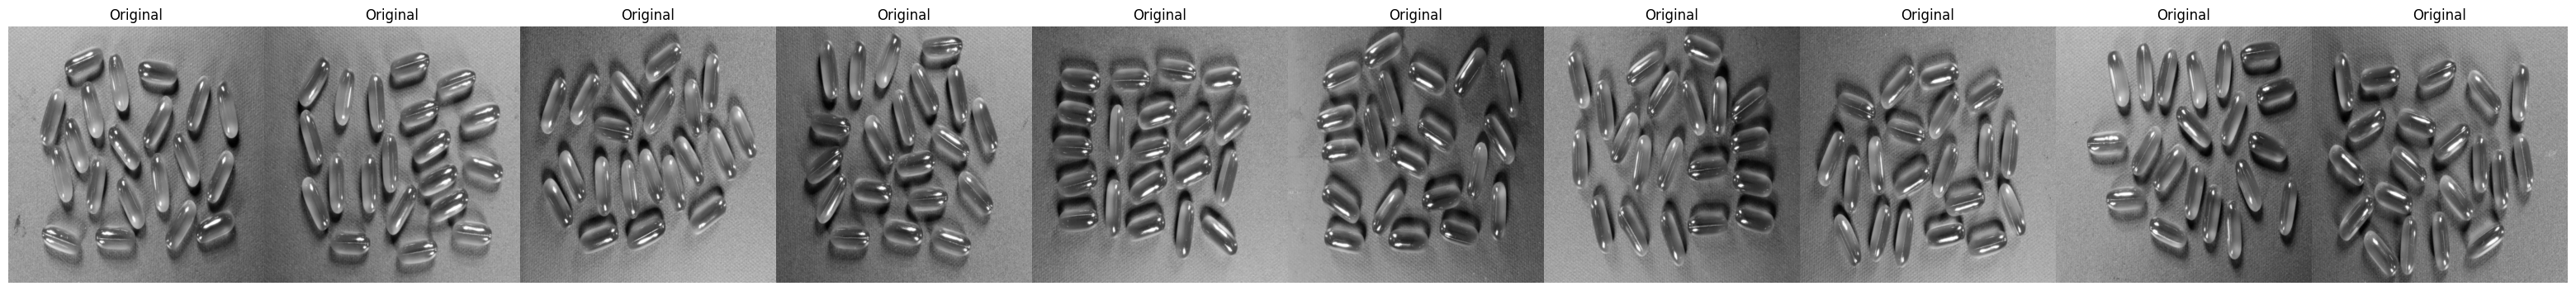

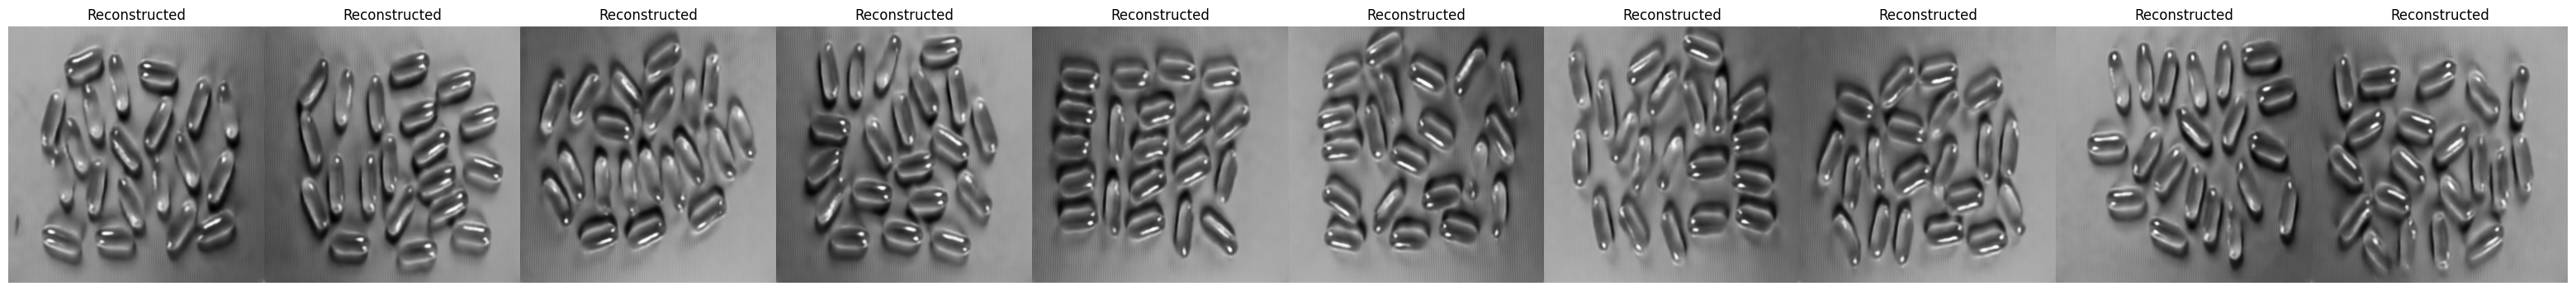

In [ ]:
# RYSUJ DLA DANYCH TRENINGOWYCH
with torch.no_grad():
    reconstructions = []
    originals = []
    count = 0
    for data in data_loader:
        if count >= 10:
            break
        data = data.to(device)
        recon_batch = model(data)
        reconstructions.append(recon_batch.cpu())
        originals.append(data.cpu())
        count += data.size(0)

#print('Reconstruction min:', reconstructions[0].min().item(), 'max:', reconstructions[0].max().item())
    
# konkatenuj listy do tensorów dal 10 obrazów
reconstructions = torch.cat(reconstructions)[:10] 
originals = torch.cat(originals)[:10]

def plot_images(images, titles, mean, std, color_mode, figsize=(40, 8), denormalize_enable=False):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)  # jeden wiersz

    if denormalize_enable:
        images = denormalize(images, mean, std)  # denormalizacja obrazów, jeśli aktywna

    for i in range(n):
        # przekształca obrazy kolorowe do formatu (wysokość, szerokość, kanały)
        if images[i].ndim == 3 and images[i].shape[0] == 3:
            image = images[i].permute(1, 2, 0)  # Zamiana osi (3, 512, 512) na (512, 512, 3)
            axes[i].imshow(image)
        else:
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
        axes[i].set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def plot_anomalies(originals, reconstructions, mean, std, color_mode, denormalize_enable=False):
    n = 10
    original_titles = ["Original"] * n
    reconstruction_titles = ["Reconstructed"] * n

    # wyświetlanie oryginalnych obrazów
    plot_images(originals[:n], original_titles, mean, std, color_mode, denormalize_enable=denormalize_enable)

    # wyświetlanie zrekonstruowanych obrazów
    plot_images(reconstructions[:n], reconstruction_titles, mean, std, color_mode, denormalize_enable=denormalize_enable)


if color_mode == "RGB":
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    mean = [0.5]
    std = [0.5]

# wyświetlanie denormalizowanych obrazów
plot_anomalies(originals, reconstructions, mean, std, color_mode, denormalize_enable=False)


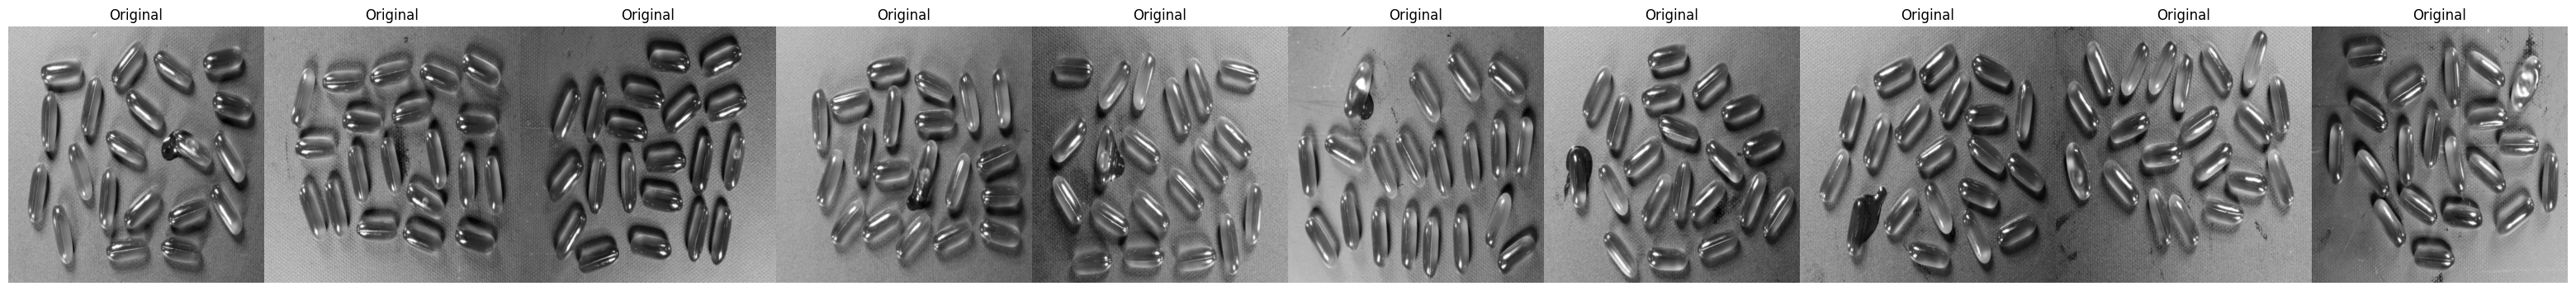

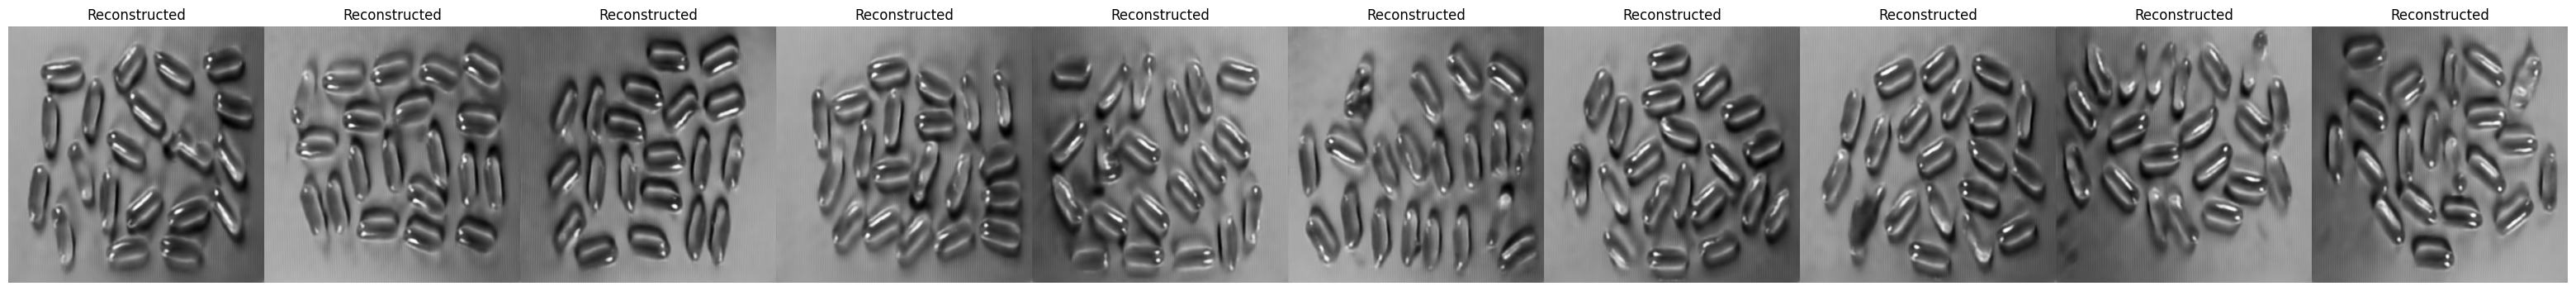

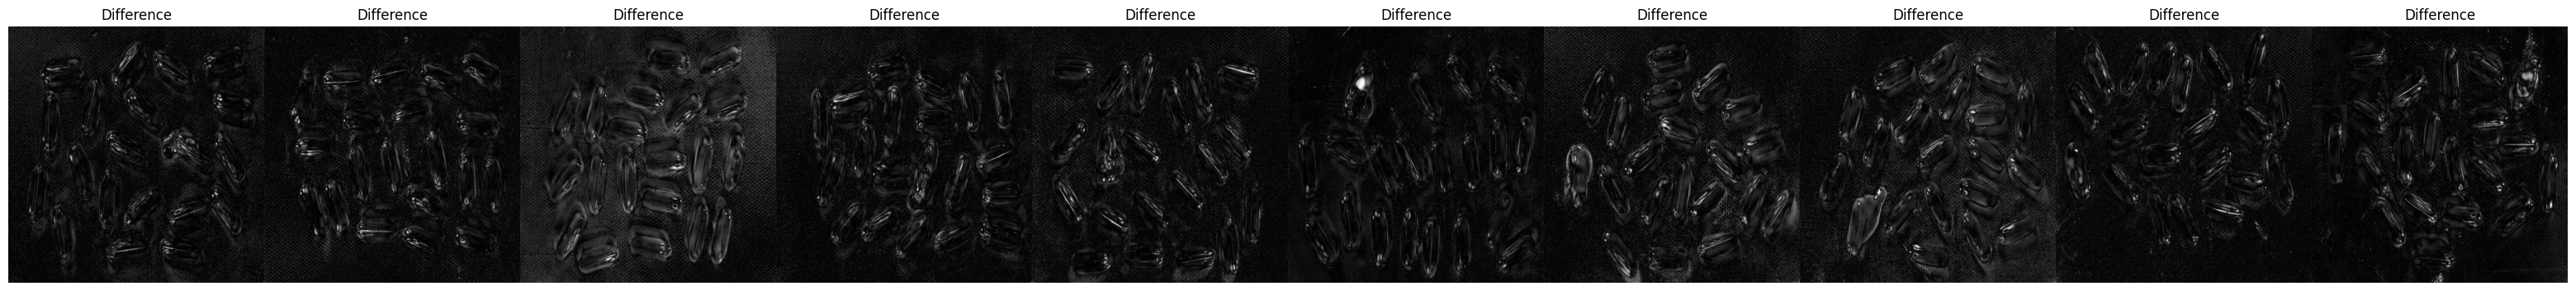

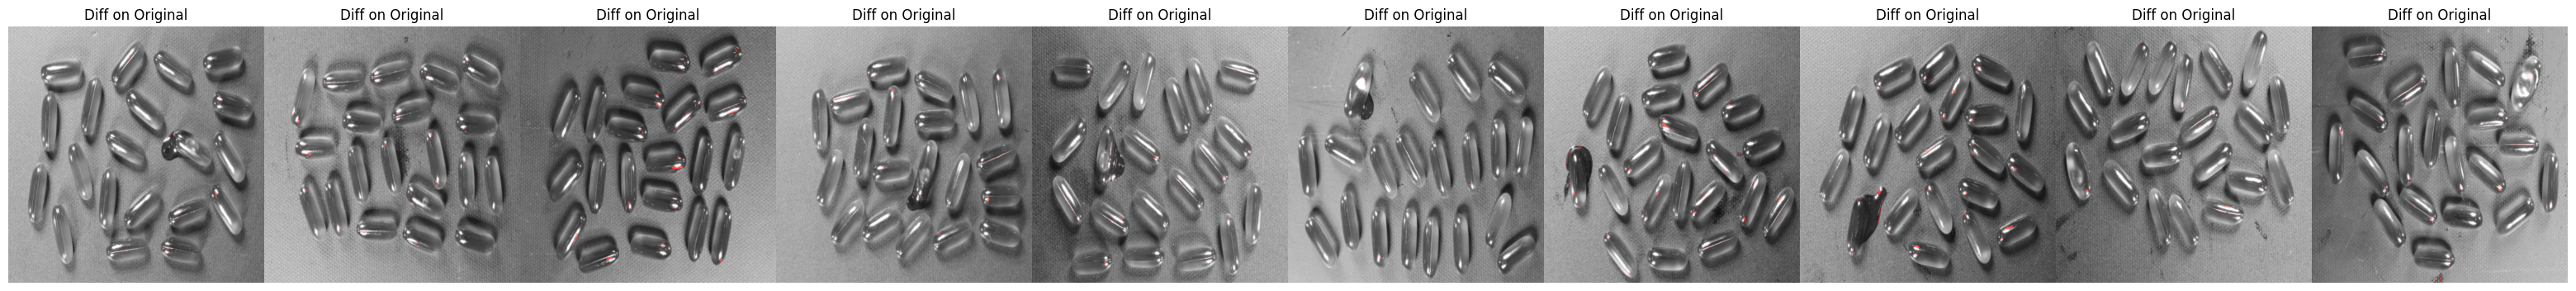

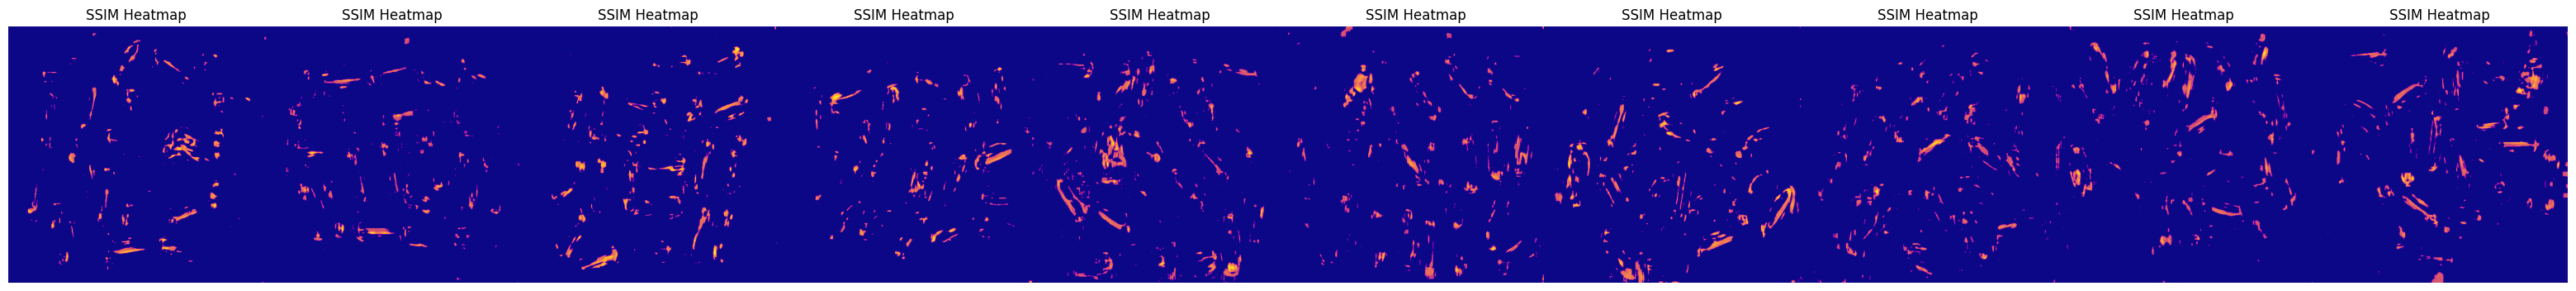

In [ ]:
# RYSUJ DLA DANYCH TESTOWYCH
with torch.no_grad():
    reconstructions_tests = []
    tests = []
    count = 0
    for data in print_loader:
        if count >= 10:
            break
        data = data.to(device)
        recon_batch = model(data)
        reconstructions_tests.append(recon_batch.cpu())
        tests.append(data.cpu())
        count += data.size(0)

reconstructions_tests = torch.cat(reconstructions_tests)[:10]
tests = torch.cat(tests)[:10]      

def plot_images(images, titles, mean, std, color_mode, denormalize_enable, figsize=(40, 8)):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)  # jeden wiersz

    if denormalize_enable:
        images = denormalize(images, mean, std)  # denormalizacja

    for i in range(n):
        if images[i].ndim == 3 and images[i].shape[0] == 3:
            image = images[i].permute(1, 2, 0)
            axes[i].imshow(image)
        else:
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
        axes[i].set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def plot_anomalies(originals, reconstructions, mean, std, color_mode, denormalize_enable):
    n = 10
    original_titles = ["Original"] * n
    reconstruction_titles = ["Reconstructed"] * n

    # wyświetlanie oryginalnych obrazów
    plot_images(originals[:n], original_titles, mean, std, color_mode, denormalize_enable)

    # wyświetlanie rekonstruowanych obrazów
    plot_images(reconstructions[:n], reconstruction_titles, mean, std, color_mode, denormalize_enable)

def plot_results(originals, reconstructions, mean, std, color_mode, denormalize_enable):
    if denormalize_enable:
        originals = denormalize(originals, mean, std)
        reconstructions = denormalize(reconstructions, mean, std)
    
    fig, axes = plt.subplots(2, 10, figsize=(40, 16))
    for i in range(10):
        if originals[i].ndim == 3 and originals[i].shape[0] == 3:
            original_image = originals[i].permute(1, 2, 0)
            reconstructed_image = reconstructions[i].permute(1, 2, 0)
            axes[0, i].imshow(original_image)
            axes[1, i].imshow(reconstructed_image)
        else:
            axes[0, i].imshow(originals[i].squeeze(), cmap='gray')
            axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruction')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def plot_differences(originals, reconstructions, mean, std, color_mode, denormalize_enable):
    if denormalize_enable:
        originals = denormalize(originals, mean, std)
        reconstructions = denormalize(reconstructions, mean, std)
    
    differences = torch.abs(originals - reconstructions)
    fig, axes = plt.subplots(1, 10, figsize=(40, 8)) 
    for i in range(10):
        if differences[i].ndim == 3 and differences[i].shape[0] == 3:
            diff_img = differences[i].permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(diff_img)
        else:
            axes[i].imshow(differences[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title('Difference')
    plt.subplots_adjust(wspace=0)
    plt.show()

def plot_diff_on_original(originals, reconstructions, mean, std, color_mode, denormalize_enable, threshold=0.1):
    if denormalize_enable:
        originals = denormalize(originals, mean, std)
        reconstructions = denormalize(reconstructions, mean, std)
    
    differences = torch.abs(originals - reconstructions)
    fig, axes = plt.subplots(1, 10, figsize=(40, 8))
    for i in range(10):
        original_img = originals[i].cpu().numpy()
        diff_img = differences[i].cpu().numpy()
        
        if originals[i].ndim == 3 and originals[i].shape[0] == 3:
            original_img = original_img.transpose(1, 2, 0)
            diff_img = diff_img.transpose(1, 2, 0)
        
        if diff_img.max() > 0: # dla dzielenia przez 0
            diff_img = (diff_img - diff_img.min()) / (diff_img.max() - diff_img.min())
        
        diff_img[diff_img < threshold] = 0
        
        if originals[i].ndim == 3 and originals[i].shape[0] == 3:
            # dla kolorwych dodaje w kanale czerwonym
            red_mask = np.zeros_like(original_img)
            red_mask[..., 0] = diff_img[..., 0]
            combined_img = np.clip(original_img + red_mask, 0, 1)
        else:
            # skala szarości- dodaje kanał czerwony
            red_mask = np.zeros((original_img.shape[1], original_img.shape[2], 3))
            red_mask[..., 0] = diff_img.squeeze()
            combined_img = np.dstack([original_img.squeeze()] * 3)  # konwersja do RGB 
            combined_img = np.clip(combined_img + red_mask, 0, 1)
        
        axes[i].imshow(combined_img)
        axes[i].axis('off')
        axes[i].set_title('Diff on Original')
    plt.subplots_adjust(wspace=0)
    plt.show()

def plot_ssim_heatmap(originals, reconstructions, mean, std, color_mode, denormalize_enable, threshold=None, win_size=11):
    if denormalize_enable:
        originals = denormalize(originals, mean, std)
        reconstructions = denormalize(reconstructions, mean, std)
    
    fig, axes = plt.subplots(1, 10, figsize=(40, 8))
    
    for i in range(10):
        original_img = originals[i].squeeze().cpu().numpy()
        recon_img = reconstructions[i].squeeze().cpu().numpy()
        
        if color_mode == 'RGB':
            original_img = np.transpose(original_img, (1, 2, 0))  # (C, H, W) -> (H, W, C)
            recon_img = np.transpose(recon_img, (1, 2, 0))
        
        # obliczanie SSIM i mapy podobieństwa z podaniem data_range i rozmiaru kernela
        ssim_value, ssim_map = ssim(original_img, recon_img, full=True, multichannel=(color_mode == 'RGB'), data_range=original_img.max() - original_img.min(), win_size=win_size)
        
        # tworzenie heatmapy z mapy SSIM
        heatmap = 1 - ssim_map  # różnice jako 1 - SSIM
        
        # opcjonalne zastosowanie wartości progowej
        if threshold is not None:
            heatmap = np.where(heatmap > threshold, heatmap, 0)
        
        # znormalizowanie heatmapy do zakresu 0-1
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        
        # wyświetlanie heatmapy z wybraną mapą kolorów
        axes[i].imshow(heatmap, cmap='plasma')
        axes[i].axis('off')
        axes[i].set_title('SSIM Heatmap')
    
    plt.subplots_adjust(wspace=0)
    plt.show()

if color_mode == "RGB":
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
else:
    mean = [0.5]
    std = [0.5]


denormalize_enable = False
plot_anomalies(tests[:10], reconstructions_tests[:10], mean, std, color_mode, denormalize_enable)
plot_differences(tests[:10], reconstructions_tests[:10], mean, std, color_mode, denormalize_enable)
plot_diff_on_original(tests[:10], reconstructions_tests[:10], mean, std, color_mode, denormalize_enable, threshold=0.5)
plot_ssim_heatmap(tests[:10], reconstructions_tests[:10], mean, std, color_mode, denormalize_enable, threshold=0.8, win_size=9)

In [ ]:
# Obliczenie PCA
from sklearn.decomposition import PCA

'''# Lista folderów z obrazami treningowymi
train_img_dirs = [
    './images/train', './images3/train', './images4/train', 
    './images5/train', './images6/train', './images7/train', 
    './images8/train', './images8/train2'
]

# Lista folderów z obrazami testowymi
test_img_dirs = [
    './images/test', './images3/test', './images4/test', 
    './images5/test', './images6/test', './images7/test', 
    './images8/test', './images8/test2'
]'''

dimms = 2

# funkcja do wyodrębnienia przestrzeni latentnej
def extract_latent_space(model, loader, device):
    latent_space = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            _, z_mean, _ = model(data)
            latent_space.append(z_mean.cpu().numpy())
    return np.concatenate(latent_space, axis=0)

model.eval()

# wyodrębnienie przestrzeni latentnej dla zbiorów treningowych i testowych
train_latent_spaces = [extract_latent_space(model, loader, device) for loader in train_loaders]
test_latent_spaces = [extract_latent_space(model, loader, device) for loader in test_loaders]

# redukcja wymiaru przy użyciu PCA
pca = PCA(n_components=dimms)
all_latent_spaces = np.concatenate(train_latent_spaces + test_latent_spaces, axis=0)
pca.fit(all_latent_spaces)

# przetworzenie przestrzeni latentnych dla zbiorów treningowych i testowych z osobna
train_latent_spaces_pca = [pca.transform(latent_space) for latent_space in train_latent_spaces]
test_latent_spaces_pca = [pca.transform(latent_space) for latent_space in test_latent_spaces]


In [ ]:
# Wizualizacja wyników PCA w 2d/3D
import plotly.graph_objs as go
import plotly.offline as pyo

# funkcja do rysowania wykresu 2D
def plot_2d():
    plt.figure(figsize=(16, 14))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']

    for idx, latent_space_pca in enumerate(train_latent_spaces_pca):
        plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], s=10, alpha=0.6, label=f'Set {idx+1} Train', c=colors[idx], marker='o')
    
    for idx, latent_space_pca in enumerate(test_latent_spaces_pca):
        plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], s=10, alpha=0.6, label=f'Set {idx+1} Test', c=colors[idx+1], marker='x')
    
    plt.title('Latent Space Visualization using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# funkcja do rysowania wykresu 3D
def plot_3d():
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    fig = go.Figure()

    for idx, latent_space_pca in enumerate(train_latent_spaces_pca):
        fig.add_trace(go.Scatter3d(
            x=latent_space_pca[:, 0],
            y=latent_space_pca[:, 1],
            z=latent_space_pca[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors[idx]),
            name=f'Set {idx+1} Train'
        ))

    for idx, latent_space_pca in enumerate(test_latent_spaces_pca):
        fig.add_trace(go.Scatter3d(
            x=latent_space_pca[:, 0],
            y=latent_space_pca[:, 1],
            z=latent_space_pca[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors[idx+1]),
            name=f'Set {idx+1} Test'
        ))

    fig.update_layout(
        title='Latent Space Visualization using PCA',
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3'
        )
    )
    
    pyo.plot(fig)

# selektor rodzaju wykresu: 2D lub 3D
if dimms == 2:
    plot_2d()
elif dimms == 3:
    plot_3d()
else:
    print("Niepoprawny wybór. Wybierz '2D' lub '3D'.")

In [ ]:
# GENERUJE OBRAZ Z LOSOWEGO WEKTORA
def generate_random_latent_vector(model, latent_dim):
    # generowanie losowego wektora latentnego
    random_latent_vector = torch.randn(1, latent_dim).to("cuda")

    # dekodowanie losowego wektora latentnego
    model.eval()
    with torch.no_grad():
        reconstructed_image = model.decode(random_latent_vector)
    
    return reconstructed_image

def show_generated_image(image):
    image = denormalize(image, mean, std)
    image = image.cpu().numpy().transpose(0, 2, 3, 1)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0], cmap='gray')
    plt.title('Generated Image from Random Latent Vector')
    plt.axis('off')
    plt.show()

latent_dim = 128
# generowanie losowego wektora latentnego i rekonstrukcja obrazu
reconstructed_image = generate_random_latent_vector(model, latent_dim)
show_generated_image(reconstructed_image)

In [ ]:
# WIZUALIZACJA LATENT SPACE
# dla zbiorów przestrzeni latenalnych wszstkich obrazów tworzy histogramy dla każdego wymiaru (waartość w wektorze od liczby wystąpień)
import plotly.graph_objects as go

# połączone dane latent spaces dla treningu i testu do wizualizacji
combined_train_latent_spaces = np.concatenate(train_latent_spaces, axis=0)
combined_test_latent_spaces = np.concatenate(test_latent_spaces, axis=0)

# funkcja do wizualizacji wszystkich linii gęstości jedna pod drugą
def plot_stacked_density_lines(latent_spaces, title):
    num_dimensions = latent_spaces.shape[1]
    fig = go.Figure()

    for i in range(num_dimensions):
        all_values = latent_spaces[:, i]
        density, bins = np.histogram(all_values, bins=50, density=True)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        offset = i * 10

        # tworzenie linii gęstości z offsetem i kolorem według gęstości
        for j in range(len(bin_centers) - 1):
            fig.add_trace(
                go.Scatter(
                    x=[bin_centers[j], bin_centers[j+1]],
                    y=[offset, offset],
                    mode='lines',
                    line=dict(color=f'rgba(0, 0, 255, {density[j] / density.max()})', width=10),
                    showlegend=False
                )
            )

    fig.update_layout(
        title=title,
        xaxis_title='Value',
        yaxis=dict(showticklabels=False),
        width=2000, 
        height=10 * num_dimensions,  # wysokość wykresu
        margin=dict(l=50, r=20, t=25, b=25)  # ustawienie marginesów
    )

    # zapisz wykres do pliku HTML
    fig.write_html(f"{title.replace(' ', '_').lower()}.html")

plot_stacked_density_lines(combined_train_latent_spaces, 'Train Latent Space Distribution')
plot_stacked_density_lines(combined_test_latent_spaces, 'Test Latent Space Distribution')


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial import distance
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ŁADOWANIE DANYCH
img_set = 2
color_mode = 'L'
input_shape = (512, 512)

transform = get_transform(color_mode, input_shape)

# OBRAZY TRENINGOWE
train_img_dirs = ['./data/train/set' + str(img_set)]
train_datasets = [CustomImageDataset(img_dirs=[img_dir], transform=transform, color_mode=color_mode) for img_dir in train_img_dirs]
train_loaders = [DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0) for dataset in train_datasets]

# OBRAZY TESTOWE DO WYŚWIETLENIA WYNIKU
test_img_dirs = ['./data/test/set' + str(img_set)]
test_datasets = [CustomImageDataset(img_dirs=[img_dir], transform=transform, color_mode=color_mode) for img_dir in test_img_dirs]
test_loaders = [DataLoader(dataset, batch_size=8, shuffle=False) for dataset in test_datasets]

print(f"Liczba obrazów w treningowym datasetcie: {len(train_datasets[0])}")
print(f"Liczba obrazów w testowym datasetcie: {len(test_datasets[0])}")

# zbieranie latent vectors z danych treningowych
latent_vectors = []
model.to(device)
model.eval()

with torch.no_grad():
    for loader in train_loaders:
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[0].to(device)
            else:
                inputs = batch.to(device)
            
            recon, mu, logvar, z = model(inputs)
            latent_vectors.append(z.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
mu_latent = torch.mean(latent_vectors, dim=0)
cov_latent = torch.cov(latent_vectors.T)

# konwersja na numpy
mu_np = mu_latent.numpy()
cov_np = cov_latent.numpy()

# dodanie małej wartości do diagonalnej, aby zapewnić inwersję
cov_np += np.eye(cov_np.shape[0]) * 1e-6

# obliczenie odwrotności macierzy kowariancji
try:
    cov_inv = np.linalg.inv(cov_np)
except np.linalg.LinAlgError:
    # Jeśli macierz jest osobliwa, użyj pseudo-inwersji
    cov_inv = np.linalg.pinv(cov_np)
    print("Macierz kowariancji była osobliwa. Użyto pseudo-inwersji.")

def mahalanobis_distance(z, mu, cov_inv):
    return distance.mahalanobis(z, mu, cov_inv)

# obliczanie odległości dla danych treningowych
training_distances = [mahalanobis_distance(z_i, mu_np, cov_inv) for z_i in latent_vectors.numpy()]

# ustalanie progu anomalii (95 percentyl)
threshold = np.percentile(training_distances, 95)
print(f"Próg anomalii: {threshold}")

# przetwarzanie danych testowych i wizualizacja
with torch.no_grad():
    for loader in test_loaders:
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[1].to(device)
            else:
                inputs = batch.to(device)
            
            recon, mu, logvar, z = model(inputs)
            z = z.cpu().numpy()
            
            # obliczenie odległości dla każdego wektora w batchu
            anomaly_scores = [mahalanobis_distance(z_i, mu_np, cov_inv) for z_i in z]
            
            # wykrywanie anomalii
            for idx, score in enumerate(anomaly_scores):
                if score > threshold:
                    status = "Wykryto anomalię"
                else:
                    status = "Obraz jest normalny."
                
                print(f"Obraz {idx+1}: {status} (Score: {score:.2f})")
            
            # wizualizacja pierwszego obrazu w batchu
            input_image = inputs[1].squeeze().cpu().numpy()
            recon_image = recon[1].squeeze().cpu().numpy()
            reconstruction_error = np.abs(input_image - recon_image)
            normalized_error = (reconstruction_error - reconstruction_error.min()) / (reconstruction_error.max() - reconstruction_error.min() + 1e-8)
            
            plt.figure(figsize=(12, 4))
            
            # oryginalny obraz
            plt.subplot(1, 3, 1)
            plt.imshow(input_image, cmap='gray')
            plt.title('Obraz Wejściowy')
            plt.axis('off')
            
            # rekonstrukcja
            plt.subplot(1, 3, 2)
            plt.imshow(recon_image, cmap='gray')
            plt.title('Rekonstrukcja')
            plt.axis('off')
            
            # heatmapa anomalii
            plt.subplot(1, 3, 3)
            plt.imshow(input_image, cmap='gray')
            plt.imshow(normalized_error, cmap='hot', alpha=0.5)
            plt.title('Mapa Anomalii')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # wizualizacja błędu jako oddzielny obraz
            plt.figure(figsize=(6, 6))
            plt.imshow(normalized_error, cmap='hot')
            plt.title('Mapa Błędu Rekonstrukcji')
            plt.colorbar()
            plt.axis('off')
            plt.show()
            
            break


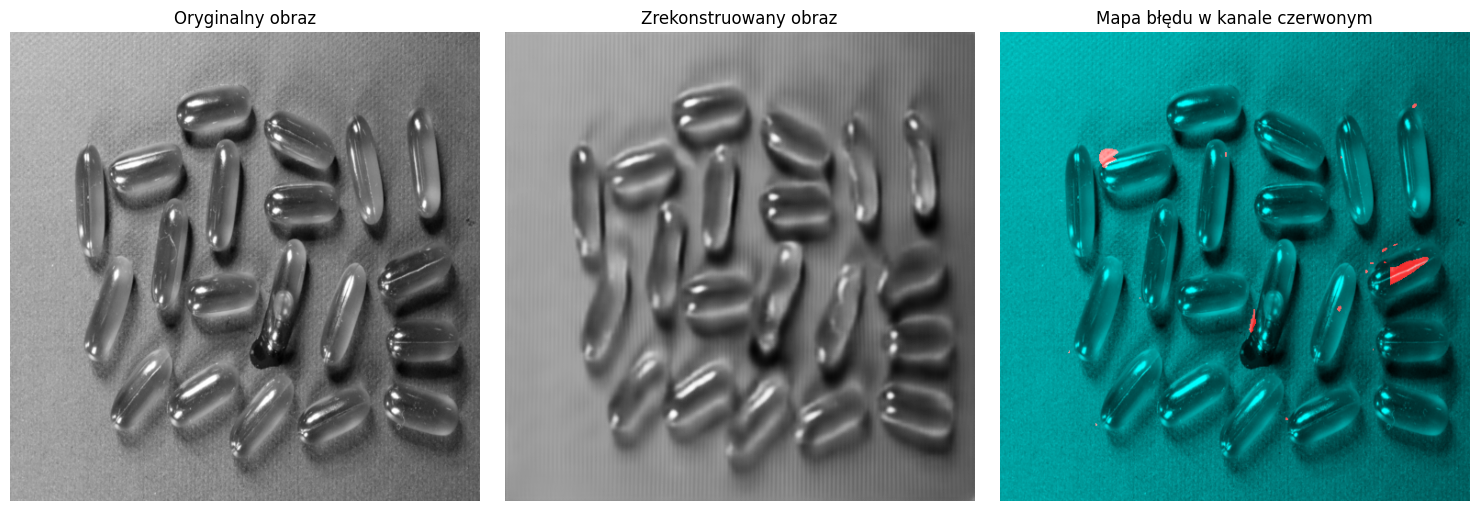

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# funkcja straty SSIM
def ssim_loss(recon_x, x, kernel_size=15):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    padding = kernel_size // 2
    mu1 = F.avg_pool2d(recon_x, kernel_size, 1, padding)
    mu2 = F.avg_pool2d(x, kernel_size, 1, padding)

    sigma1 = F.avg_pool2d(recon_x ** 2, kernel_size, 1, padding) - mu1 ** 2
    sigma2 = F.avg_pool2d(x ** 2, kernel_size, 1, padding) - mu2 ** 2
    sigma12 = F.avg_pool2d(recon_x * x, kernel_size, 1, padding) - mu1 * mu2

    ssim_n = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    ssim_d = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2)
    ssim = ssim_n / ssim_d

    recon_loss = torch.clamp(( ssim) / 2, 0, 1)
    return recon_loss

# funkcja wizualizująca
def visualize_reconstruction(recon_x, x, kernel_size=15):
    with torch.no_grad():
        ssim_map = ssim_loss(recon_x, x, kernel_size=kernel_size).cpu().numpy()

    # Konwersja do numpy dla obrazów wejściowych
    recon_x_np = recon_x[0].permute(1, 2, 0).cpu().numpy()
    x_np = x[0].permute(1, 2, 0).cpu().numpy()

    # Tworzenie wykresów
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(x_np, cmap='gray')
    axs[0].set_title("Oryginalny obraz")
    axs[0].axis('off')

    axs[1].imshow(recon_x_np, cmap='gray')
    axs[1].set_title("Zrekonstruowany obraz")
    axs[1].axis('off')

    axs[2].imshow(1 - ssim_map[0, :, :], cmap='hot')
    axs[2].set_title("Mapa błędu (1-SSIM)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# funkcja wizualizująca z mapą błędu w kanale czerwonym
def visualize_reconstruction_with_red_overlay(recon_x, x, kernel_size=11, threshold=None):
    with torch.no_grad():
        # Obliczamy mapę błędu SSIM
        ssim_map = ssim_loss(recon_x, x, kernel_size=kernel_size).cpu().numpy()

    # Konwersja do numpy dla obrazów wejściowych (usuwamy wymiar batch i kanał)
    recon_x_np = recon_x[0, 0].cpu().numpy()  # Obraz zrekonstruowany
    x_np = x[0, 0].cpu().numpy()  # Oryginalny obraz
    ssim_map_np = 1 - ssim_map[0, 0]  # Mapa błędu SSIM (1 - SSIM)

    # Zastosowanie progu, jeśli podano
    if threshold is not None:
        # Chcemy pokazać obszary z większym błędem, więc wyzerujemy te, które mają SSIM powyżej progu
        ssim_map_np[ssim_map_np < (threshold)] = 0

    # Normalizacja obrazów do zakresu [0, 1]
    x_normalized = (x_np - x_np.min()) / (x_np.max() - x_np.min())
    ssim_map_normalized = (ssim_map_np - ssim_map_np.min()) / (ssim_map_np.max() - ssim_map_np.min())

    # Tworzenie obrazu RGB z mapą błędu w kanale czerwonym
    overlay_image = np.stack([ssim_map_normalized, x_normalized, x_normalized], axis=-1)

    # Tworzenie wykresów
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(x_np, cmap='gray')
    axs[0].set_title("Oryginalny obraz")
    axs[0].axis('off')

    axs[1].imshow(recon_x_np, cmap='gray')
    axs[1].set_title("Zrekonstruowany obraz")
    axs[1].axis('off')

    axs[2].imshow(overlay_image)
    axs[2].set_title("Mapa błędu w kanale czerwonym")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

image_index = 3
img1 = tests[image_index].cpu().unsqueeze(0)
img2 = reconstructions_tests[image_index].cpu().unsqueeze(0)

visualize_reconstruction_with_red_overlay(img2, img1, kernel_size=21, threshold=.9)

